In [1]:
import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn import svm
import sympy
import math
from math import e
import random
from keras import Model
from keras.models import load_model
import numpy as np
import os
import pandas as pd

2021-12-20 23:40:54.018491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-20 23:40:54.018534: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dic = {
    'gene':'./data/gene/GRCh37.gene.bed',
    'non_gene':'./data/gene/non_gene.bed',
    'non_gene_4':'./data/gene/non_gene_4.bed',
    'non_gene_2':'./data/gene/non_gene_2.bed',
    'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1':'./data/051.bam',
    'bam2':'./data/051_2.bam',
    'bam3':'./data/051_3.bam',
    'bam123':'./data/051_123.bam',
    'bam4':'./data/051_4.bam',
    'bam5':'./data/051_5.bam',
    'TSS_low':'./data/gene/low_expressed.bed',
    'TSS_HK':'./data/gene/HK.bed',
    'TSS_silent':'./data/gene/silent_gene_TSS.bed',
    'ATAC_hema_1':'./data/gene/ATAC_hema_1.bed',
    'ATAC_hema_2':'./data/gene/ATAC_hema_2.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Brain':'./data/gene/ATAC_Brain.bed'
    }
TSS_HK = []
with open(dic['TSS_HK'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['1']:
            TSS_HK.append(TSS(ll[0], int(int(ll[1])+1000)))
# with open(dic['ATAC_hema_1'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         TSS_HK.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))
# with open(dic['ATAC_hema_2'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         TSS_HK.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))
# with open(dic['ATAC_Bcell'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['1'] and ll[2] == '0':
#             TSS_HK.append(TSS(ll[0],int(ll[1])))        

TSS_NonGene = []
with open(dic['non_gene'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        TSS_NonGene.append(TSS(ll[0], int(ll[1])+int(1000)))

bamfile = ps.AlignmentFile(dic['bam123'],'rb')

TSS_NonGene = TSS_NonGene[:len(TSS_HK)]

TSSes_x = TSS_HK + TSS_NonGene
TSSes_y = [1]*len(TSS_HK) + [0]*len(TSS_NonGene)
perm = random.sample(range(len(TSSes_x)),len(TSSes_x))
TSSes_x = np.array(TSSes_x)
TSSes_y = np.array(TSSes_y)
TSSes_x = TSSes_x[perm[:len(perm)]]
TSSes_y = TSSes_y[perm[:len(perm)]]
labels = TSSes_y
up = 1000
down = 1000


In [3]:
#lstm
feature_matrix = []
for j, tss in enumerate(TSSes_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    wps = np.zeros(up+down, dtype=float)
    win = 120
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
            # wps_total
            region1 = int(max(0, ss + win/2))
            region2 = int(min(ee - win/2, end-start))
            i = region1
            while i < region2:
                wps[i] += 1
                i = i+1
            # wps_part
            region1 = int(max(0, ss - win/2))
            region2 = int(min(end-start, ss + win/2))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i + 1
            # wps_part
            region1 = int(max(ee - win/2, 0))
            region2 = int(min(ee + win/2, end-start))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i+1
    k = 0
    win = 40
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        ff.append(int(round(np.mean(wps[ss:ee]))))
        feature_win[k] = np.array(ff)
        k = k + 1
    feature_matrix.append(feature_win)
feature_matrix = np.array(feature_matrix)

lstm_x = []
for mat in feature_matrix:
    lstm_x.append(mat)
lstm_x = np.array(lstm_x)


In [4]:
#lstm
tss_pre = []
with open(dic['ATAC_Bcell'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['2'] and ll[2] == '0':
            tss_pre.append(TSS(ll[0],int(ll[1])))
feature_matrix_pre = []
for j, tss in enumerate(tss_pre):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    wps = np.zeros(up+down, dtype=float)
    win = 120
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
            # wps_total
            region1 = int(max(0, ss + win/2))
            region2 = int(min(ee - win/2, end-start))
            i = region1
            while i < region2:
                wps[i] += 1
                i = i+1
            # wps_part
            region1 = int(max(0, ss - win/2))
            region2 = int(min(end-start, ss + win/2))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i + 1
            # wps_part
            region1 = int(max(ee - win/2, 0))
            region2 = int(min(ee + win/2, end-start))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i+1
    k = 0
    win = 40
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        ff.append(int(round(np.mean(wps[ss:ee]))))
        feature_win[k] = np.array(ff)
        k = k + 1
    feature_matrix_pre.append(feature_win)
feature_matrix_pre = np.array(feature_matrix_pre)

lstm_x_pre = []
for mat in feature_matrix_pre:
    lstm_x_pre.append(mat)
lstm_x_pre = np.array(lstm_x_pre)

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import KFold
from keras.layers import Input,Conv2D,Activation,Dense,Lambda,Flatten,Embedding,PReLU,BatchNormalization,Bidirectional,LSTM
from keras.models import Model
from tensorflow.keras.utils import to_categorical
import numpy as np
from keras.callbacks import EarlyStopping

In [11]:
train_x = lstm_x[:int(len(lstm_x)*0.8)]
train_y = labels[:int(len(labels)*0.8)]
test_x = lstm_x[int(len(lstm_x)*0.8):]
test_y = labels[int(len(labels)*0.8):]
def create_model():
    feature_size = 2
    num_classes = 2

    inputs = Input(shape=(lstm_x.shape[1], lstm_x.shape[2]))
    x = Bidirectional(LSTM(50, return_sequences=True))(inputs)
    x = Flatten()(x)
    x = Dense(300)(x)
    x = PReLU()(x)
    x = Dense(16)(x)
    x = PReLU()(x)
    x = Dense(feature_size)(x)
    feature = PReLU(name='feature')(x)
    out = Dense(num_classes,activation='softmax')(feature)
    lambda_c=0
    input_target = Input(shape=(1,))
    centers = Embedding(num_classes, feature_size,name='centers')(input_target)
    l2_loss = Lambda(lambda x: K.sum(K.square(x[0]-x[1][:,0]),1,keepdims=True),name='l2_loss')([feature, centers])
    model_train = Model(inputs=[inputs, input_target], outputs=[out, l2_loss])
    model_train.compile(optimizer='adam',
                            loss=["categorical_crossentropy",lambda y_true,y_pred:y_pred],
                            loss_weights=[1,lambda_c/2.],
                            metrics=["acc"])
    model_predict = Model(inputs,out)
    model_predict.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
    return model_train, model_predict

n_split = 5
x = lstm_x
id = []
ypred = np.empty(shape=[0,2])
y = labels
for train_index, test_index in KFold(n_split).split(x):   
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_train_one_hot = to_categorical(y_train)
    y_test_one_hot = to_categorical(y_test)
    model_train, model_predict = create_model()
    y_test_one_hot = to_categorical(y_test)
    dummy_matrix1 = np.zeros((x_train.shape[0],1))
    dummy_matrix2 = np.zeros((x_test.shape[0],1))
    model_train.fit(x=[x_train,y_train],y=[y_train_one_hot,dummy_matrix1],batch_size=128,epochs=100,verbose=0)#,validation_data=([x_test,y_test],[y_test_one_hot,dummy_matrix2]),callbacks=[EarlyStopping(monitor="val_loss",patience=20)])
    pp = model_predict(x_test).numpy()
    id += list(test_index)
    ypred = np.concatenate((ypred, pp))
x_train = x[id]
y_train = labels[id]

In [12]:
def creat_model():
    model = keras.Sequential()
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(50, return_sequences=True),input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=None, bias_regularizer=None))
    model.add(keras.layers.Dropout(0.2))
    # model.add(keras.layers.Dense(2, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='4'))
    model.add(keras.layers.Dense(2, activation='softmax', kernel_regularizer=None, bias_regularizer=None))
    adam = keras.optimizers.Adam(lr=1e-4)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
t = [[],[]]
for i in range(len(y_train)):
    t[y_train[i]].append(i)
t0 = np.mean([ypred[i][0]for i in t[0]])
t1 = np.mean([ypred[i][1]for i in t[1]])
print(t0,t1)
yconf = []
for i in range(len(ypred)):
    if ypred[i][0] > ypred[i][1] and ypred[i][0] >= t0:
        yconf.append(0)
    elif ypred[i][1] > ypred[i][0] and ypred[i][1] >= t1:
        yconf.append(1)
    else:
        yconf.append(-1)
matrix_c = np.zeros((2,2),dtype=int)
for i in range(len(y_train)):
    if yconf[i] == -1:
        continue
    matrix_c[y_train[i]][yconf[i]] += 1

matrix_c1 = np.zeros((2,2),dtype=float)
for i in range(2):
    for j in range(2):
        matrix_c1[i][j] = matrix_c[i][j] * len([k for k in y_train if k == i]) / np.sum(matrix_c[i])
print(matrix_c)
print(matrix_c1)
matrix_q = np.zeros((2,2),dtype=float)
for i in range(2):
    for j in range(2):
        matrix_q = matrix_c1 / np.sum(matrix_c1)
print(matrix_q)
print(len([i for i in yconf if i == -1]))

0.9250539200711143 0.918924277656554
[[332  21]
 [ 22 330]]
[[347.04815864  21.95184136]
 [ 23.0625     345.9375    ]]
[[0.47025496 0.02974504]
 [0.03125    0.46875   ]]
33


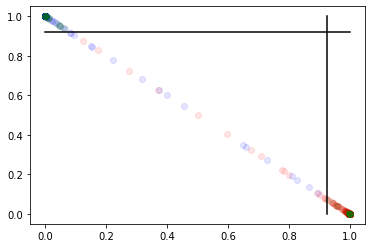

0.3082815734989648


In [14]:
'''cl method 2'''
exclude = []
reserved_0 = []
reserved_1 = []
for i, tt in enumerate(yconf):
    if tt == -1:
        if y_train[i] == 0:
            reserved_0.append(i)
        else:
            reserved_1.append(i)
        continue
    if y_train[i] != yconf[i]:
        if y_train[i] == 0:
            exclude.append(i)
            continue
        else:
            exclude.append(i)
            continue
    if y_train[i] == 0:
        reserved_0.append(i)
    else:
        reserved_1.append(i)
ex = np.array([ypred[i] for i in exclude])
re_0 = np.array([ypred[i] for i in reserved_0])
re_1 = np.array([ypred[i] for i in reserved_1])

plt.scatter(re_0[:,0],re_0[:,1],color='r',alpha=0.1)
plt.scatter(re_1[:,0],re_1[:,1],color='b',alpha=0.1)

plt.scatter(ex[:,0],ex[:,1],color='g',alpha=0.1)
plt.plot([t0,t0],[0,1],color='black')
plt.plot([0,1],[t1,t1],color='black')
plt.show()
reserved_id = np.array(reserved_0 + reserved_1)
perm = random.sample(range(len(reserved_id)),len(reserved_id))
reserved_id = reserved_id[perm[:len(perm)]]
reserved_x = x_train[reserved_id]
reserved_y = y_train[reserved_id]
# train_x = reserved_x[:int(len(reserved_x)*0.8)]
# train_y = keras.utils.to_categorical(reserved_y[:int(len(reserved_y)*0.8)])
# test_x = reserved_x[int(len(reserved_x)*0.8):]
# test_y = keras.utils.to_categorical(reserved_y[int(len(reserved_y)*0.8):])
train_x = reserved_x
train_y = keras.utils.to_categorical(reserved_y)
model = creat_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(train_x, train_y, epochs=100, batch_size=128,verbose=0)#, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./0_cl.h5', save_best_only=True)], shuffle=True, verbose=2,)
# model.evaluate(test_x,test_y)
# print(len(exclude),len(reserved_1),len(reserved_0))
# model = creat_model()
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# model.fit(lstm_x, keras.utils.to_categorical(labels), epochs=100, batch_size=128,verbose=0)#, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./0_nl.h5', save_best_only=True)], shuffle=True, verbose=2,)
ppp = model.predict(lstm_x_pre)
countp = 0
for p in ppp:
    if p[0] <= p[1]:
        countp += 1
print(countp/len(ppp))

In [ ]:
'''method 3'''

import cleanlab
pbc = cleanlab.pruning.get_noise_indices(y_train, np.array(ypred), prune_method='prune_by_class',n_jobs=1)
reserved_id = []
for i in range(len(pbc)):
    if pbc[i] == False:
        reserved_id.append(i)
model = creat_model()
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# model.fit(reserved_x, keras.utils.to_categorical(reserved_y), epochs=200, batch_size=128, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./'+str(noise_fraction*100)+'/cl_3.h5', save_best_only=True)], shuffle=True, verbose=0)
model.fit(reserved_x, keras.utils.to_categorical(reserved_y), epochs=100, batch_size=128,verbose=0)#, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./'+str(noise_fraction*100)+'/cl_3.h5', save_best_only=True)], shuffle=True, verbose=0)
ppp = model.predict(lstm_x_pre)
countp = 0
for p in ppp:
    if p[0] <= p[1]:
        countp += 1
print(countp/len(ppp))